## Xử lý dữ liệu

### Load dữ liệu

In [74]:
import pandas as pd
import numpy as np

data = pd.read_csv('./datasets/diabetes.csv')


In [75]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Chia tập dữ liệu ra X, y tương ứng

In [40]:
X, y = data.iloc[:, :-1].values, data.iloc[:, -1].values

Số lượng mẫu và đặc trưng

In [41]:
N, d = X.shape

print("Num. samples: ", N)
print("Num. features/variables: ", d)

Num. samples:  768
Num. features/variables:  8


## Nhắc lại các bước của thuật toán PCA
1. Chuẩn hóa dữ liệu
2. Xây dựng ma trận hiệp phương sai từ dữ liệu đã được chuẩn hoá
3. Tìm các vector riêng, trị riêng của ma trận hiệp phương sai 
4. Xây dựng tập trực chuẩn từ tập hợp các vector trên
5. Sắp xếp các trị riêng theo chiều giảm dần
6. Chọn $k$ vector riêng đầu tiên ứng với $k$ trị riêng đầu tiên trong bộ trị riêng có thứ tự ở bước trên $(k << d)$
7. Xây dựng ma trận chiếu $W$ từ các vector riêng trên
8. Tìm hình chiếu $Y$ của ma trận dữ liệu $X$ trong không gian mới sinh bởi ma trận $W$, khi đó $Y$ = $WX$

## Xây dựng thuật toán PCA từ các bước trên biết:

Công thức chuẩn hoá  
$$X_{std} = \frac{X - \bar{X}}{S}$$
Với S là độ lệch chuẩn có công thức
$$S^2 = \frac{\sum_{i=1}^{n} (X - \bar{X})^2}{N-1}$$

Công thức tính ma trận hiệp phương sai cho dữ liệu đã chuẩn hoá
$$Cov =  \frac{X_{std}^TX_{std}}{N-1}$$

Tìm vector riêng và trị riêng sử dụng `np.linalg.eigh`


Sắp xếp các trị riêng theo chiều giảm dần

In [45]:
def find_eigen(X):
    '''
    Trả về trị riêng và vector riêng đã sắp xếp giảm dần theo trị riêng
    '''
    # Chuẩn hóa dữ liệu với phương sai hiệu chỉnh
    N = X.shape[0]
    S = sum((X - X.mean(axis=0))**2)/(N-1)
    X_std = (X - X.mean(axis = 0))/np.sqrt(S)

    # Tính ma trận hiệp phương sai
    cov_mat =(X_std.T @ X_std) / (N - 1)

    # Tìm trị riêng, vector riêng của ma trận hiệp phương sai mẫu
    eigenvals, eigenvecs = np.linalg.eigh(cov_mat)

    # Sắp xếp cặp (trị riêng, vector riêng) với trị riêng theo chiều giảm dần
    eigenpairs = [(abs(eigenval), eigenvec) for (eigenval, eigenvec) in zip(eigenvals, eigenvecs.T)]
    eigenpairs = sorted(eigenpairs, key = lambda pair: pair[0], reverse = True)

    return eigenpairs


In [46]:
eigenpairs = find_eigen(X)
# 1) Lấy ra các trị riêng
eigenvals = [eigenval for (eigenval, _) in eigenpairs]
eigenvals = np.array(eigenvals) 


## Tìm  số PC tương ứng với 30% và 50% dữ liệu

In [47]:
# utils
def find_num_pc(eigenpairs, thres = 0.95):
    '''
    Tìm số lượng vector thành phần chính
    -----------------------
    Các tham số:
        eigenpairs: list-like
            Cặp (trị riêng, vector riêng) có từ thuật toán PCA
        thres: float, default = 0.95
            Ngưỡng thông tin ta muốn giữ lại từ dữ liệu (mặc định ta giữ lại 95% dữ liệu ban đầu)
    -----------------------
    Trả về:
        Số lượng vector thành phần chính
    '''
    # 1) Lấy ra các trị riêng
    eigenvals = [eigenval for (eigenval, _) in eigenpairs]
    eigenvals = np.array(eigenvals)
    
    # 2) Tính tổng dồn các trị riêng
    cumsum = np.cumsum(eigenvals)
    
    # 3) Tính phần trăm
    cumsum /= cumsum[-1]

    # 4) Lặp từng phần tử trong cumsum, khi nào phần trăm cộng dồn vừa đến ngưỡng thì ta dừng
    for i, val in enumerate(cumsum):
        if val >= thres:
            return i + 1


In [66]:
find_num_pc(eigenpairs,thres=0.3)

2

## Xây dựng ma trận W  và hình chiếu từ các vector riêng đó

Xây dựng ma trận W

In [48]:

def construct_W(eigenpairs):
    '''
    Xây dựng ma trận chiếu W từ cặp (trị riêng, vector riêng) có được từ thuật toán PCA
    -----------------------
    Các tham số:
        eigenpairs: list-like
            Danh sách các cặp (trị riêng, vector riêng) có từ thuật toán PCA
    -----------------------
    Trả về: numpy-ndarray
        Ma trận phép chiếu W trong đó mỗi dòng là một vector riêng
    '''
    eigenvecs = [eigenvec for (_, eigenvec) in eigenpairs]
    W = np.array([e.T for e in eigenvecs])
    return W


Tạo ma trận chiếu và hình chiếu ứng với số PC tìm được ở trên (30% và 50% dữ liệu)

In [49]:
W1 = construct_W(eigenpairs[:2])
W2 = construct_W(eigenpairs[:3])

In [50]:
# Hình chiếu ứng với 2 components
W1 = construct_W(eigenpairs[:2])
X_proj_eig_2pc = W1 @ X_std.T
X_proj_eig_2pc = X_proj_eig_2pc.T

# Hình chiếu ứng với 3 components
W2 = construct_W(eigenpairs[:3])
X_proj_eig_3pc = W2 @ X_std.T
X_proj_eig_3pc = X_proj_eig_3pc.T

## Trực quan hóa kết quả

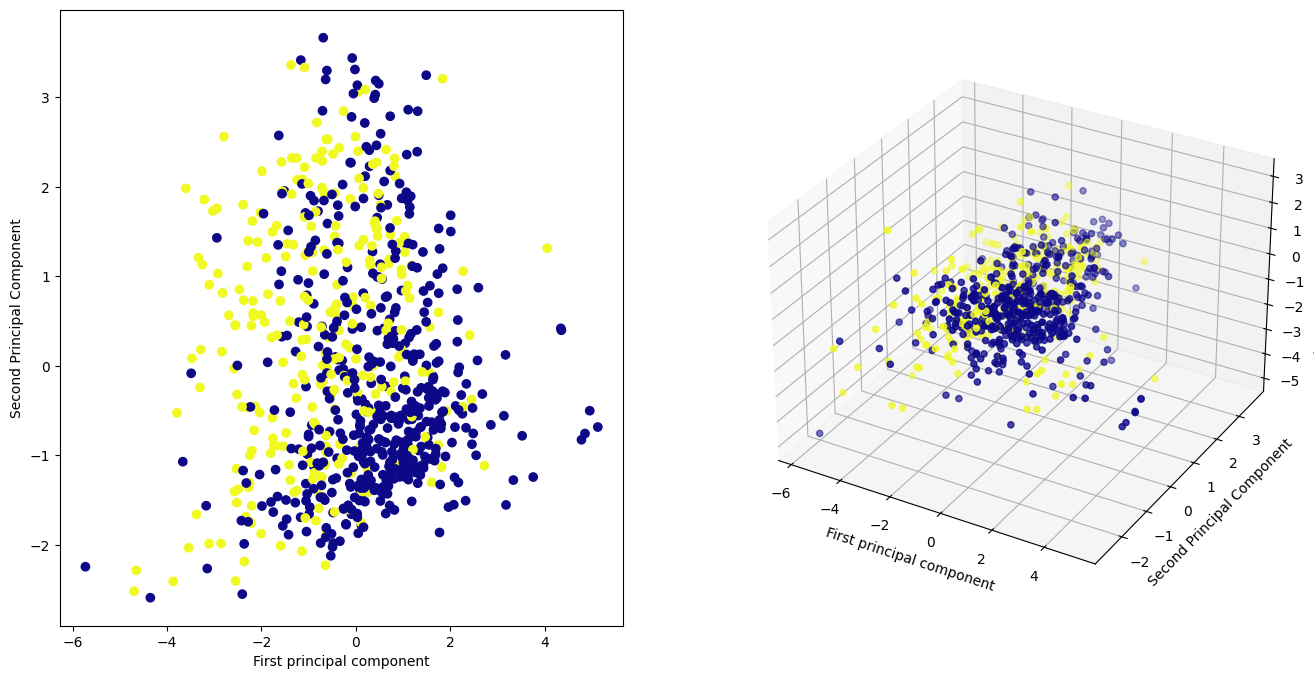

In [79]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
ax1.scatter(X_proj_eig_2pc[:,0],X_proj_eig_2pc[:,1],c=y,cmap='plasma')
ax1.set_xlabel('First principal component')
ax1.set_ylabel('Second Principal Component')



ax2= fig.add_subplot(122, projection='3d')

# Sử dụng hàm scatter với ba thành phần chính
ax2.scatter(X_proj_eig_3pc[:, 0], X_proj_eig_2pc[:, 1], X_proj_eig_3pc[:, 2], c=y, cmap='plasma')

# Đặt nhãn cho các trục
ax2.set_xlabel('First principal component')
ax2.set_ylabel('Second Principal Component')
ax2.set_zlabel('Third Principal Component')

plt.show()


In [61]:
# 3D visualization

import matplotlib.pyplot as plt
import plotly.express as px # package for 3D visualization
# scatter with predicted clusters
fig = px.scatter_3d(X_proj_eig_3pc, 
                    x=X_proj_eig_3pc[:,0], 
                    y=X_proj_eig_3pc[:,1], 
                    z=X_proj_eig_3pc[:,2], 
                    color=y, 
                    width=800, 
                    height=400)
# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# Chuẩn hóa dữ liệu bằng thư viện 
sc = StandardScaler()
X_std = sc.fit_transform(X)

pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_std)